Compare a larger set of Ising models trained on the same data to identify sloppy and stiff directions in parameter space.

In [1]:
import os
import pandas
import numpy as np
import torch
import matplotlib.pyplot as plt
import hcpdatautils as hcp
import isingutils as ising

In [2]:
int_type = torch.int
float_type = torch.float
device = torch.device('cuda')

In [3]:
num_nodes = 21
num_reps = 100
num_epochs = 28800
num_windows = 96
subject_id = 885975
learning_rate = '0.001'
data_threshold = '0.100'

In [3]:
num_nodes = 21
num_reps = 1000
num_epochs = 28800
num_windows = 96
subject_id = 516742
learning_rate = '0.001'
data_threshold = '0.100'

In [5]:
num_nodes = 90
num_reps = 100
num_epochs = 72000
num_windows = 240
subject_id = 516742
learning_rate = '0.001'
data_threshold = '0.100'

In [4]:
model_dir = 'E:\\Ising_model_results_daai'
file_suffix = f'nodes_{num_nodes}_reps_{num_reps}_epochs_{num_epochs}_window_{num_windows}_lr_{learning_rate}_threshold_{data_threshold}_subject_{subject_id}.pt'
h_file_name = os.path.join(model_dir, f'h_{file_suffix}')
h = torch.load(h_file_name)
print( 'h size:', h.size() )
J_file_name = os.path.join(model_dir, f'J_{file_suffix}')
J = torch.load(J_file_name)
print( 'J size:', J.size() )

h size: torch.Size([1000, 21])
J size: torch.Size([1000, 21, 21])


In [5]:
data_dir = 'E:\\HCP_data'
data_ts_original = hcp.load_all_time_series_for_subject(directory_path=data_dir, subject_id=subject_id, dtype=float_type, device=device)
data_ts = ising.standardize_and_binarize_ts_data(ts=data_ts_original).flatten(start_dim=0, end_dim=1)
print( 'data_ts size:', data_ts.size() )
data_fc_all = hcp.get_fc(ts=data_ts)
print( 'data_fc size:', data_fc_all.size() )
data_fc = data_fc_all[:num_nodes, :num_nodes]

data_ts size: torch.Size([4800, 360])
data_fc size: torch.Size([360, 360])


In [6]:
batch_size = h.size(dim=0)
num_time_points = data_ts.size(dim=0)
_, _, state = ising.get_batched_ising_models(batch_size=batch_size, num_nodes=num_nodes, dtype=float_type, device=device)
sim_ts_batch = torch.zeros( (batch_size, num_time_points, num_nodes), dtype=float_type, device=device )
sim_ts_batch, state = ising.run_batched_balanced_metropolis_sim(sim_ts=sim_ts_batch, J=J, h=h, s=state, num_steps=num_time_points)
print( 'sim_ts_batch size:', sim_ts_batch.size() )

sim_ts_batch size: torch.Size([1000, 4800, 21])


In [7]:
sim_fc_batch = hcp.get_fc_batch(ts_batch=sim_ts_batch)
print( 'sim_fc_batch size:', sim_fc_batch.size() )

sim_fc_batch size: torch.Size([1000, 21, 21])


In [8]:
data_fc_rep = data_fc.unsqueeze(dim=0).repeat( (batch_size,1,1) )
fc_rmse = hcp.get_triu_rmse_batch(tensor1=sim_fc_batch, tensor2=data_fc_rep)
print( 'fc_rmse size:', fc_rmse.size() )
fc_corr = hcp.get_triu_corr_batch(tensor1=sim_fc_batch, tensor2=data_fc_rep)
print( 'fc_corr size:', fc_corr.size() )

fc_rmse size: torch.Size([1000])
fc_corr size: torch.Size([1000])


In [9]:
def plot_value_histogram(name:str, values:torch.Tensor, data_subset:str):
    print( values.min().item(), values.median().item(), values.max().item() )
    values_np = values.flatten().detach().cpu().numpy()
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    axs.hist(values_np)
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.set_xlabel(f'{name} value')
    axs.set_ylabel('count in bin')
    axs.set_title(f'distribution of {name} for models trained on {data_subset} data')
    plt.show()

In [10]:
def print_stats(name:str, values:torch.Tensor):
    quantile_cutoffs = torch.tensor([0.025, 0.5, 0.975], dtype=float_type, device=device)
    quantiles = torch.quantile(values, quantile_cutoffs)
    min_val = torch.min(values)
    max_val = torch.max(values)
    print(f'The distribution of {name} values has median {quantiles[1].item():.3g} with 95% CI [{quantiles[0].item():.3g}, {quantiles[2].item():.3g}] and range [{min_val.item():.3g}, {max_val.item():.3g}].')

0.010821085423231125 0.015943532809615135 0.03927186504006386


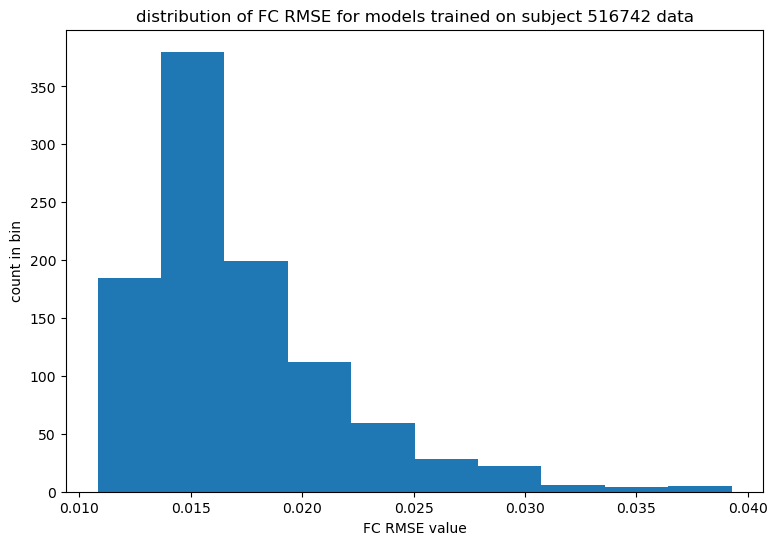

The distribution of FC RMSE values has median 0.0159 with 95% CI [0.012, 0.0291] and range [0.0108, 0.0393].


In [11]:
plot_value_histogram(name='FC RMSE', values=fc_rmse, data_subset=f'subject {subject_id}')
print_stats(name='FC RMSE', values=fc_rmse)

0.9923129677772522 0.996044933795929 0.9975132346153259


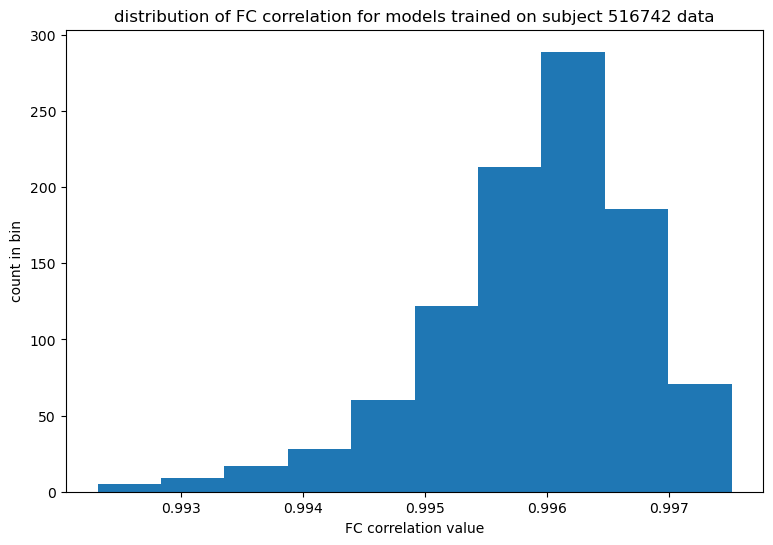

The distribution of FC correlation values has median 0.996 with 95% CI [0.994, 0.997] and range [0.992, 0.998].


In [12]:
plot_value_histogram(name='FC correlation', values=fc_corr, data_subset=f'subject {subject_id}')
print_stats(name='FC correlation', values=fc_corr)

In [13]:
region_names_all, region_coords_all = hcp.load_roi_info(directory_path=data_dir, dtype=float_type, device=device)
region_names = region_names_all[:num_nodes]
# https://www.geeksforgeeks.org/python-all-possible-pairs-in-list/
region_pair_names = [f'({from_node},{to_node})' for idx, from_node in enumerate(region_names) for to_node in region_names[idx + 1:]]
print( 'num distinct region pairs:', len(region_pair_names) )

num distinct region pairs: 210


h has a standard deviation of 0.0896 over all regions, while standard deviations for individual regions range from 0.00514 to 0.0169.


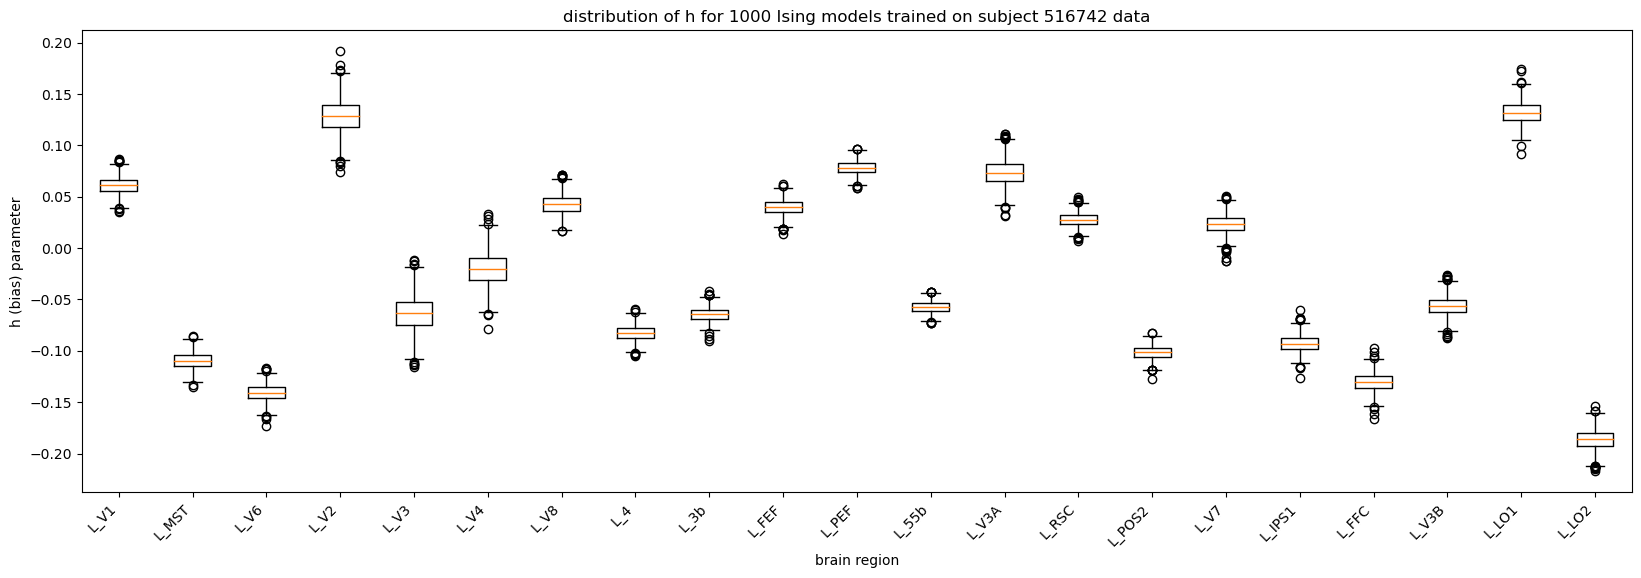

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
axs.boxplot( h.detach().cpu().numpy() )
axs.set_xticklabels( region_names, rotation=45, ha='right' )
axs.set_xlabel('brain region')
axs.set_ylabel('h (bias) parameter')
axs.set_title(f'distribution of h for {batch_size} Ising models trained on subject {subject_id} data')
h_std_overall, h_mean_overall = torch.std_mean(h)
h_stds, h_means = torch.std_mean(h, dim=0)
print(f'h has a standard deviation of {h_std_overall:.3g} over all regions, while standard deviations for individual regions range from {h_stds.min():.3g} to {h_stds.max():.3g}.')

J_flat size: torch.Size([1000, 210])
J has a standard deviation of 0.298 over all region pairs, while standard deviations for individual pairs range from 0.00972 to 0.177.


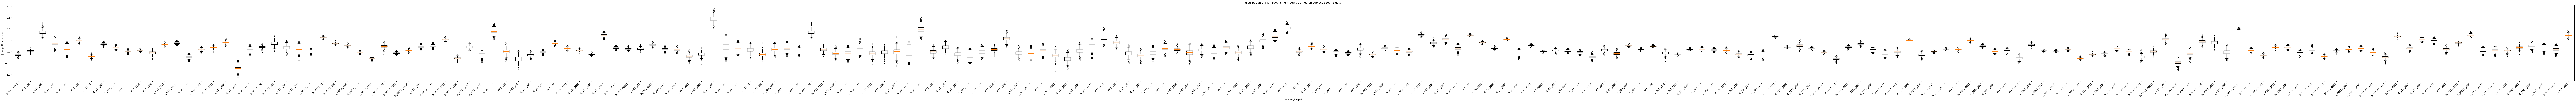

In [15]:
region_pair_indices = torch.triu_indices( row=num_nodes, col=num_nodes, offset=1, device=device )
J_flat = J[ :, region_pair_indices[0], region_pair_indices[1] ]
print( 'J_flat size:', J_flat.size() )
# pair_rows = region_pair_indices[0]
# pair_cols = region_pair_indices[1]
# num_region_pairs = region_pair_indices.size(dim=1)
# J_flat = torch.zeros( (batch_size, num_region_pairs), dtype=float_type, device=device )
# for rep in range(batch_size):
#     J_rep = J[rep,:,:]
#     J_flat[rep,:] = J[rep,pair_rows,pair_cols]
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(200, 6))
axs.boxplot( J_flat.detach().cpu().numpy() )
axs.set_xticklabels( region_pair_names, rotation=45, ha='right' )
axs.set_xlabel('brain region pair')
axs.set_ylabel('J (weight) parameter')
axs.set_title(f'distribution of J for {batch_size} Ising models trained on subject {subject_id} data')
J_std_overall, J_mean_overall = torch.std_mean(J_flat)
J_stds, J_means = torch.std_mean(J_flat, dim=0)
print(f'J has a standard deviation of {J_std_overall:.3g} over all region pairs, while standard deviations for individual pairs range from {J_stds.min():.3g} to {J_stds.max():.3g}.')

In [16]:
params_flat = torch.cat(  (h, J_flat), dim=1  )
print( 'params_flat size:', params_flat.size() )
params_flat_std, params_flat_mean = torch.std_mean(params_flat, dim=0, keepdim=True)
params_flat_centered = params_flat - params_flat_mean
# h and J values get added to and subtracted from each other directly, so they should be directly comparable.
# params_flat_centered = (params_flat - params_flat_mean)/params_flat_std
param_names = [*region_names, *region_pair_names]

params_flat size: torch.Size([1000, 231])


Text(0.5, 1.0, 'distributions of parameter z-scores for 1000 Ising models trained on subject 516742 data')

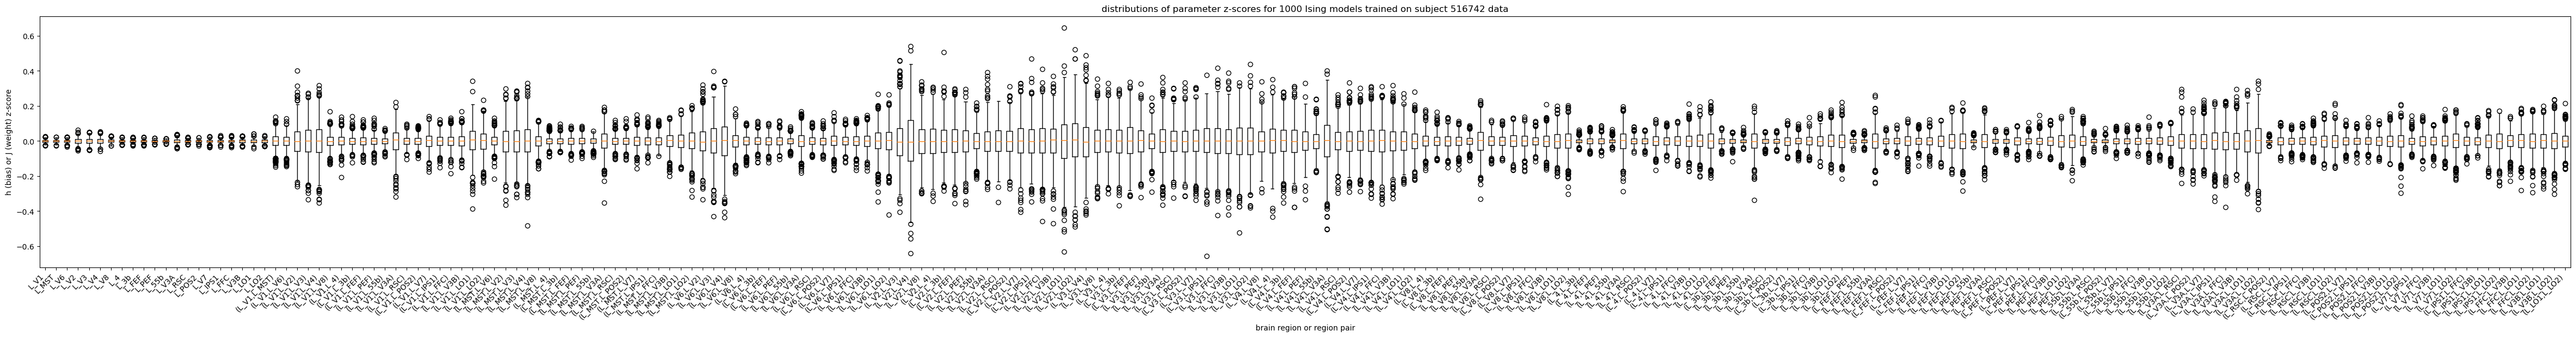

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(60, 6))
axs.boxplot( params_flat_centered.detach().cpu().numpy() )
axs.set_xticklabels(param_names, rotation=45, ha='right')
axs.set_xlabel('brain region or region pair')
axs.set_ylabel('h (bias) or J (weight) z-score')
axs.set_title(f'distributions of parameter z-scores for {batch_size} Ising models trained on subject {subject_id} data')

In [18]:
# Because of the randomness inherent to the fitting process,
# it is unlikely that any two rows (replications) or any two columns (parameters) would be exactly linearly dependent.
# As such, we can fairly safely assume that the rank is min(num rows, num columns).
rank = min( params_flat.size(dim=0), params_flat.size(dim=1) )
U, S, V = torch.pca_lowrank(params_flat_centered, q=rank, center=False, niter=10000)
print( 'U size:', U.size() )
print( 'S size:', S.size() )
print( 'V size:', V.size() )

U size: torch.Size([1000, 231])
S size: torch.Size([231])
V size: torch.Size([231, 231])


The eigenvalues of the principal components range from 0.0737 to 7.95.


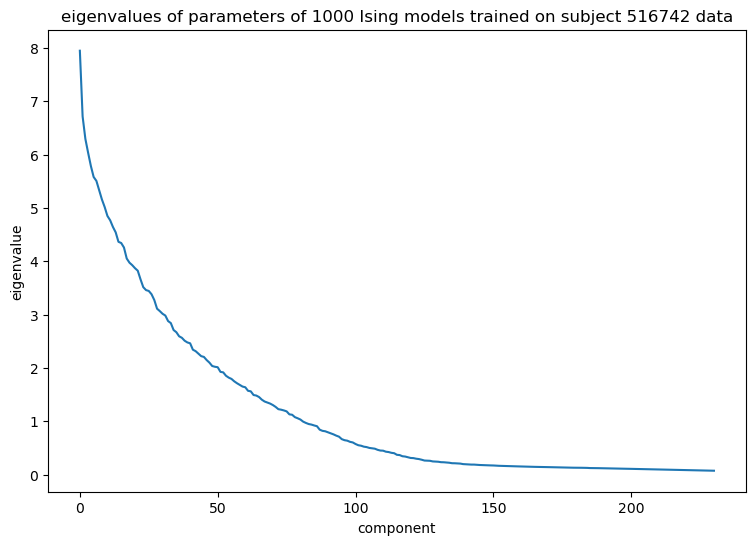

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.plot( S.detach().cpu().numpy() )
axs.set_xlabel('component')
axs.set_ylabel('eigenvalue')
axs.set_title(f'eigenvalues of parameters of {batch_size} Ising models trained on subject {subject_id} data')
print( f'The eigenvalues of the principal components range from {S.min():.3g} to {S.max():.3g}.' )

Text(0.5, 1.0, 'cumulative explained variance for 1000 Ising models trained on subject 516742 data')

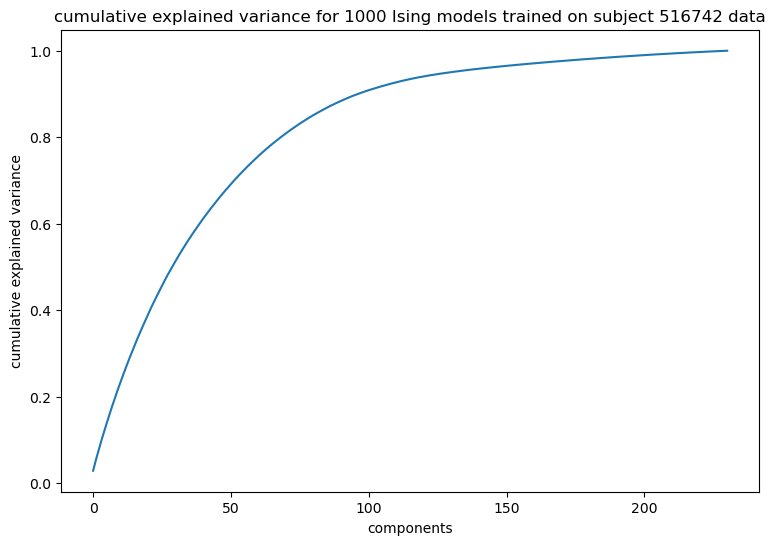

In [20]:
cum_var_exp = torch.cumsum( S/S.sum(), dim=0 )
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.plot( cum_var_exp.detach().cpu().numpy() )
axs.set_xlabel('components')
axs.set_ylabel('cumulative explained variance')
axs.set_title(f'cumulative explained variance for {batch_size} Ising models trained on subject {subject_id} data')
# print( f'The eigenvalues of the principal components range from {S.min():.3g} to {S.max():.3g}.' )

In [21]:
reconstruction_errors = torch.zeros( (rank,), dtype=float_type, device=device )
for num_components in range(rank):
    params_reconstructed = torch.matmul(  U[:,:num_components], torch.matmul( torch.diag(S[:num_components]), V[:,:num_components].transpose(dim0=0,dim1=1) )  )
    reconstruction_errors[num_components] = hcp.get_rmse(params_flat_centered, params_reconstructed)
print( 'reconstruction_errors size:', reconstruction_errors.size() )

reconstruction_errors size: torch.Size([231])


The RMSE of the parameters reconstructed from principal components ranges from 0.000153 to 0.0619.


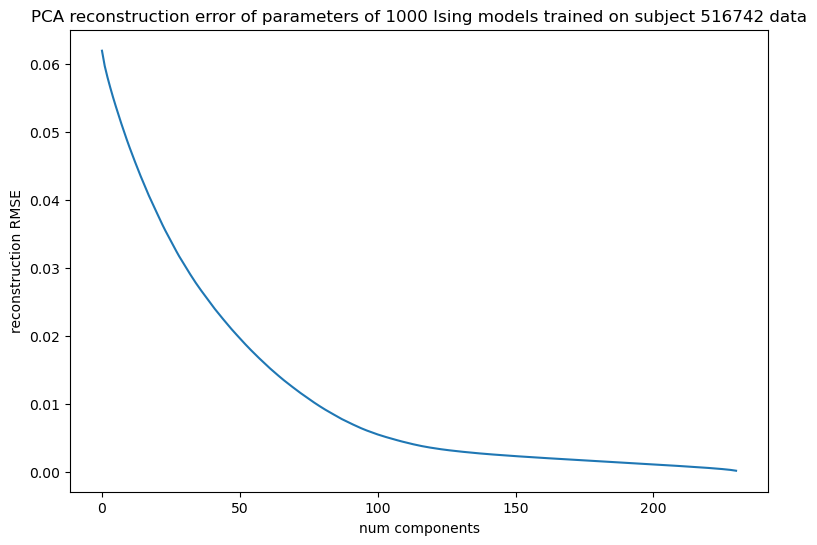

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.plot( reconstruction_errors.detach().cpu().numpy() )
axs.set_xlabel('num components')
axs.set_ylabel('reconstruction RMSE')
axs.set_title(f'PCA reconstruction error of parameters of {batch_size} Ising models trained on subject {subject_id} data')
print( f'The RMSE of the parameters reconstructed from principal components ranges from {reconstruction_errors.min():.3g} to {reconstruction_errors.max():.3g}.' )

Pearson correlation between sim-vs-data FC RMSE and PC 1 is 0.0415.


Text(0.5, 1.0, 'FC RMSE vs PC 1 of 1000 Ising models trained on subject 516742 data')

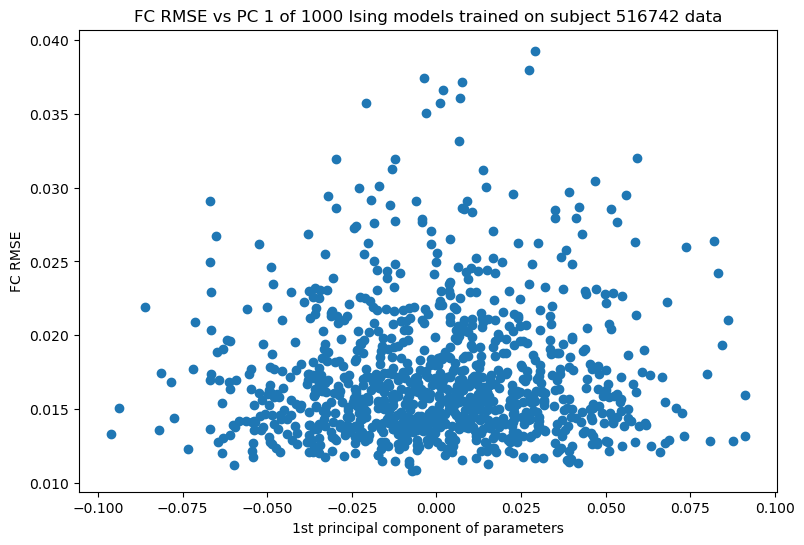

In [23]:
pc_index = 0
cc_rmse_vs_pc = torch.corrcoef(  torch.stack( (U[:,pc_index],fc_rmse), dim=0 )  )[0,1]
print(f'Pearson correlation between sim-vs-data FC RMSE and PC {pc_index+1} is {cc_rmse_vs_pc:0.3g}.')
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.scatter( U[:,pc_index].detach().cpu().numpy(), fc_rmse.detach().cpu().numpy() )
axs.set_xlabel('1st principal component of parameters')
axs.set_ylabel('FC RMSE')
axs.set_title(f'FC RMSE vs PC {pc_index+1} of {batch_size} Ising models trained on subject {subject_id} data')

Pearson correlation between sim-vs-data FC correlation and PC 1 is 0.00372.


Text(0.5, 1.0, 'FC correlation vs PC 1 of 1000 Ising models trained on subject 516742 data')

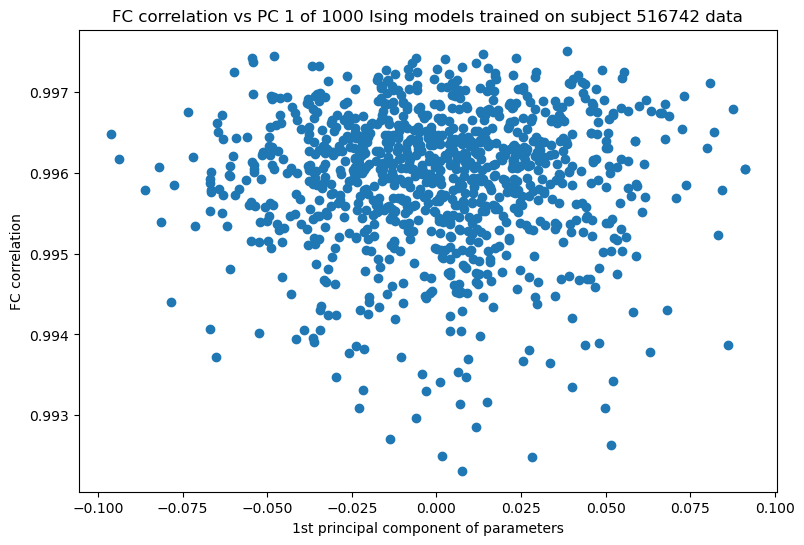

In [24]:
pc_index = 0
cc_corr_vs_pc = torch.corrcoef(  torch.stack( (U[:,pc_index],fc_corr), dim=0 )  )[0,1]
print(f'Pearson correlation between sim-vs-data FC correlation and PC {pc_index+1} is {cc_corr_vs_pc:0.3g}.')
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.scatter( U[:,pc_index].detach().cpu().numpy(), fc_corr.detach().cpu().numpy() )
axs.set_xlabel('1st principal component of parameters')
axs.set_ylabel('FC correlation')
axs.set_title(f'FC correlation vs PC {pc_index+1} of {batch_size} Ising models trained on subject {subject_id} data')

In [25]:
R_squared_rmse = torch.zeros( (rank+1,), dtype=float_type, device=device )
# R_squared_rmse_ret = torch.zeros( (rank+1,), dtype=float_type, device=device )
ss_tot_fc_rmse = torch.sum(  torch.pow( fc_rmse - torch.mean(fc_rmse), 2.0 )  )
# print(ss_tot_fc_rmse)
fc_rmse_col = fc_rmse.unsqueeze(dim=1)
# print( fc_rmse_col.size() )
ones_col = torch.ones( (batch_size,1), dtype=float_type, device=device )
U_with_intercept = torch.cat( (ones_col, U), dim=1 )
for component_index in range(rank+1):
    num_components = component_index+1
    U_subset = U_with_intercept[:,:num_components]
    # print( U[:,:num_components].size() )
    (solution, residuals_rmse_ret, rank_lstsq, singular_values_lstsq) = torch.linalg.lstsq(U_subset, fc_rmse_col)
    fc_rmse_pred = torch.matmul(U_subset, solution)
    residuals_rmse = fc_rmse_col - fc_rmse_pred
    ss_res_fc_rmse = torch.sum( torch.pow(residuals_rmse, 2.0) )
    #print(ss_res_fc_rmse)
    # print(component_index, U[0,:num_components])
    R_squared_rmse[component_index] = 1 - ss_res_fc_rmse/ss_tot_fc_rmse
    # print( ss_res_fc_rmse, residuals_rmse_ret )
print( 'R_squared size: ', R_squared_rmse.size() )

R_squared size:  torch.Size([232])


Text(0.5, 1.0, 'linear regression prediction of FC RMSE from PCs for 1000 Ising models trained on subject 516742 data')

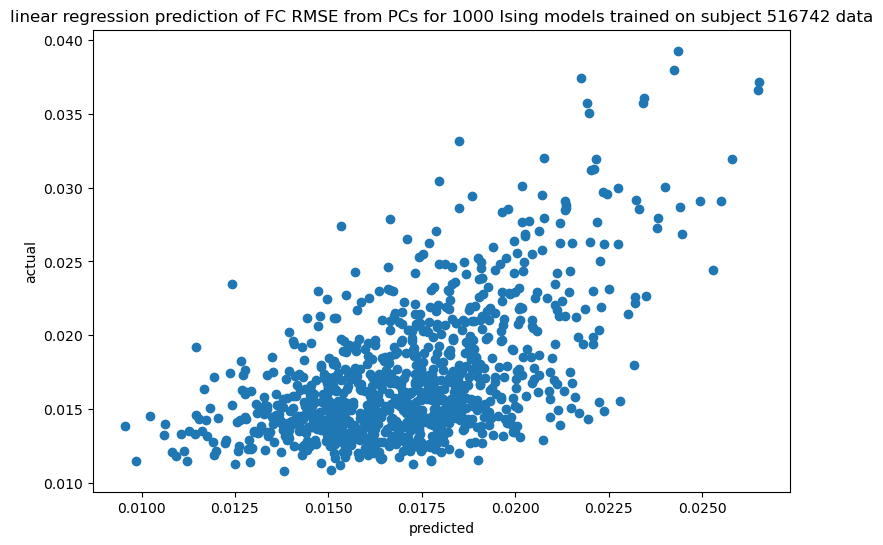

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.scatter( fc_rmse_pred.detach().cpu().numpy(), fc_rmse.detach().cpu().numpy() )
axs.set_xlabel('predicted')
axs.set_ylabel('actual')
axs.set_title(f'linear regression prediction of FC RMSE from PCs for {batch_size} Ising models trained on subject {subject_id} data')

The R^2 for PCs as predictors of FC RMSE ranges from 0 to 0.328.


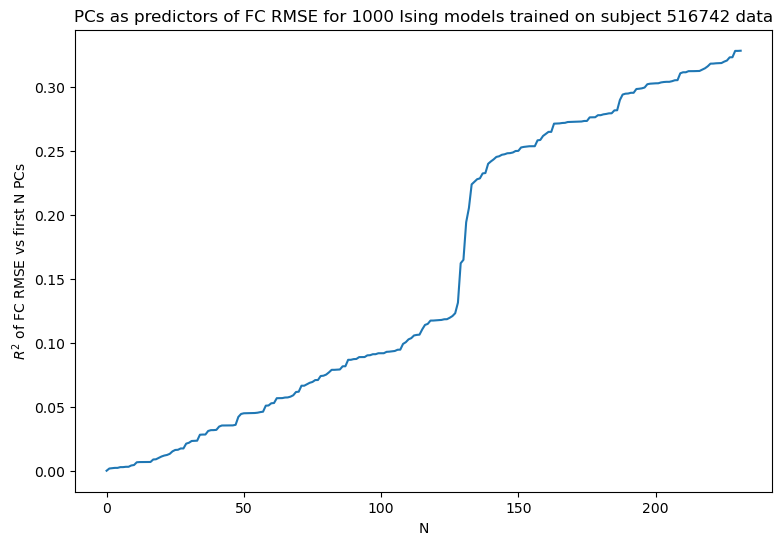

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.plot( R_squared_rmse.detach().cpu().numpy() )
axs.set_xlabel('N')
axs.set_ylabel('$R^2$ of FC RMSE vs first N PCs')
axs.set_title(f'PCs as predictors of FC RMSE for {batch_size} Ising models trained on subject {subject_id} data')
print( f'The R^2 for PCs as predictors of FC RMSE ranges from {R_squared_rmse.min():.3g} to {R_squared_rmse.max():.3g}.' )

In [28]:
R_squared_corr = torch.zeros( (rank+1,), dtype=float_type, device=device )
# R_squared_corr_ret = torch.zeros( (rank+1,), dtype=float_type, device=device )
ss_tot_fc_corr = torch.sum(  torch.pow( fc_corr - torch.mean(fc_corr), 2.0 )  )
print(ss_tot_fc_corr)
fc_corr_col = fc_corr.unsqueeze(dim=1)
# print( fc_rmse_col.size() )
ones_col = torch.ones( (batch_size,1), dtype=float_type, device=device )
U_with_intercept = torch.cat( (ones_col, U), dim=1 )
for component_index in range(rank+1):
    num_components = component_index+1
    U_subset = U_with_intercept[:,:num_components]
    # print( U[:,:num_components].size() )
    (solution, residuals_corr_ret, rank_lstsq, singular_values_lstsq) = torch.linalg.lstsq(U_subset, fc_corr_col)
    fc_corr_pred = torch.matmul(U_subset, solution)
    residuals_corr = fc_corr_col - fc_corr_pred
    ss_res_fc_corr = torch.sum( torch.pow(residuals_corr, 2.0) )
    # print(ss_res_fc_corr)
    # print(component_index, U[0,:num_components])
    R_squared_corr[component_index] = 1 - ss_res_fc_corr/ss_tot_fc_corr
    # print(R_squared_corr[component_index])
    # print( ss_res_fc_rmse, residuals_rmse_ret )
print( 'R_squared size: ', R_squared_corr.size() )

tensor(0.0007, device='cuda:0')
R_squared size:  torch.Size([232])


The R^2 for PCs as predictors of FC correlation ranges from 0 to 0.243.


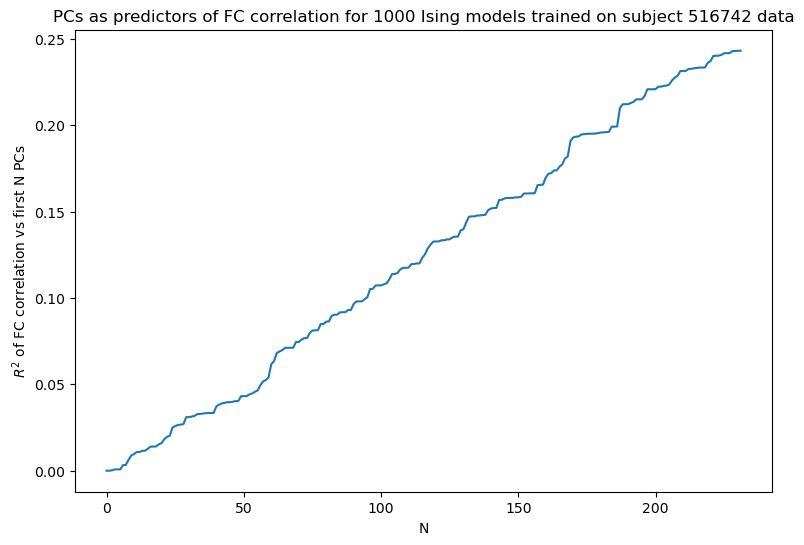

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.plot( R_squared_corr.detach().cpu().numpy() )
axs.set_xlabel('N')
axs.set_ylabel('$R^2$ of FC correlation vs first N PCs')
axs.set_title(f'PCs as predictors of FC correlation for {batch_size} Ising models trained on subject {subject_id} data')
print( f'The R^2 for PCs as predictors of FC correlation ranges from {R_squared_corr.min():.3g} to {R_squared_corr.max():.3g}.' )

In [30]:
def get_fisher_info_matrix(ts:torch.Tensor):
    print( 'ts size:', ts.size() )
    num_nodes = ts.size(dim=-1)
    device = ts.device
    ut_indices = torch.triu_indices( row=num_nodes, col=num_nodes, offset=1, device=device )
    J_vars = ts[:,:,:,None] * ts[:,:,None,:]
    print( 'J_vars size:', J_vars.size() )
    J_vars_ut = J_vars[:, :, ut_indices[0], ut_indices[1] ]
    print( 'J_vars_ut size:', J_vars_ut.size() )
    all_vars = torch.cat( (ts, J_vars_ut), dim=-1 )
    print( 'all_vars size:', all_vars.size() )
    mean_of_prods = torch.mean( all_vars[:,:,:,None] * all_vars[:,:,None,:], dim=1 )
    print( 'mean_of_prods size:', mean_of_prods.size() )
    mean_vars = torch.mean(all_vars, dim=1)
    prod_of_means = mean_vars[:,:,None] * mean_vars[:,None,:]
    print( 'prod_of_means size:', prod_of_means.size() )
    return mean_of_prods - prod_of_means

In [31]:
# Make a slower version that uses less GPU memory.
def get_fisher_info_matrix_low_mem(ts:torch.Tensor):
    print( 'ts size:', ts.size() )
    num_reps = ts.size(dim=0)
    num_nodes = ts.size(dim=-1)
    num_vars = num_nodes + num_nodes*(num_nodes-1)//2
    dtype = ts.dtype
    device = ts.device
    fim_batch = torch.zeros( (num_reps, num_vars, num_vars), dtype=dtype, device=device )
    ut_indices = torch.triu_indices( row=num_nodes, col=num_nodes, offset=1, device=device )
    for rep in range(num_reps):
        ts_rep = ts[rep,:,:]
        J_vars = ts_rep[:,:,None] * ts_rep[:,None,:]
        # print( 'J_vars size:', J_vars.size() )
        J_vars_ut = J_vars[:, ut_indices[0], ut_indices[1] ]
        # print( 'J_vars_ut size:', J_vars_ut.size() )
        all_vars = torch.cat( (ts_rep, J_vars_ut), dim=-1 )
        # print( 'all_vars size:', all_vars.size() )
        mean_of_prods = torch.mean(all_vars[:,:,None] * all_vars[:,None,:], dim=0)
        # print( 'mean_of_prods size:', mean_of_prods.size() )
        mean_vars = torch.mean(all_vars, dim=0)
        prod_of_means = mean_vars[:,None] * mean_vars[None,:]
        # print( 'prod_of_means size:', prod_of_means.size() )
        fim_batch[rep,:,:] = mean_of_prods - prod_of_means
    return fim_batch

In [32]:
# Make a slower version that uses less GPU memory.
def get_fisher_info_matrix_lower_mem(ts:torch.Tensor):
    print( 'ts size:', ts.size() )
    num_reps, num_time_points, num_nodes = ts.size()
    num_pairs = num_nodes*(num_nodes-1)//2
    num_vars = num_nodes + num_pairs
    dtype = ts.dtype
    device = ts.device
    fim_h_h_batch = torch.zeros( (num_reps, num_nodes, num_nodes), dtype=dtype, device=device )
    fim_h_J_batch = torch.zeros( (num_reps, num_nodes, num_pairs), dtype=dtype, device=device )
    fim_J_h_batch = torch.zeros( (num_reps, num_pairs, num_nodes), dtype=dtype, device=device )
    fim_J_J_batch = torch.zeros( (num_reps, num_pairs, num_pairs), dtype=dtype, device=device )
    ut_indices = torch.triu_indices( row=num_nodes, col=num_nodes, offset=1, device=device )
    # Find Fisher information for all h-h pairs.
    for var1_index in range(num_nodes-1):
        var1 = ts[:,:,var1_index]
        for var2_index in range(var1_index+1, num_nodes):        
            var2 = ts[:,:,var2_index]
            fim_h_h_batch[:,var1_index,var2_index] = torch.mean(var1 * var2, dim=1) - torch.mean(var1, dim=1) * torch.mean(var2, dim=1)
    fim_h_h_batch = fim_h_h_batch + torch.transpose(fim_h_h_batch, dim0=-2, dim1=-1) + torch.eye(n=num_nodes, dtype=dtype, device=device)
    # Find Fisher information for all h-J pairs.
    for var1_index in range(num_nodes):
        var1 = ts[:,:,var1_index]
        for var2_index in range(num_pairs):
            var2_node1 = ut_indices[0,var2_index]
            var2_node2 = ut_indices[1,var2_index]
            var2 = ts[:,:,var2_node1] * ts[:,:,var2_node2]
            fim_h_J_batch[:,var1_index,var2_index] = torch.mean(var1 * var2, dim=1) - torch.mean(var1, dim=1) * torch.mean(var2, dim=1)
    # Find Fisher information for all J-h pairs.
    # for var1_index in range(num_pairs):
    #     var1_node1 = ut_indices[0,var1_index]
    #     var1_node2 = ut_indices[1,var1_index]
    #     var1 = ts[:,:,var1_node1] * ts[:,:,var1_node2]
    #     for var2_index in range(num_nodes):
    #         var2 = ts[:,:,var2_index]
    #         fim_J_h_batch[:,var1_index,var2_index] = torch.mean(var1 * var2, dim=1) - torch.mean(var1, dim=1) * torch.mean(var2, dim=1)
    # Actually, it is just the transpose of all h-J pairs.
    fim_J_h_batch = torch.transpose(fim_h_J_batch, dim0=-2, dim1=-1)
    # Find Fisher information for all J-J pairs.
    for var1_index in range(num_pairs-1):
        var1_node1 = ut_indices[0,var1_index]
        var1_node2 = ut_indices[1,var1_index]
        var1 = ts[:,:,var1_node1] * ts[:,:,var1_node2]
        for var2_index in range(var1_index+1, num_pairs):
            var2_node1 = ut_indices[0,var2_index]
            var2_node2 = ut_indices[1,var2_index]
            var2 = ts[:,:,var2_node1] * ts[:,:,var2_node2]
            fim_J_J_batch[:,var1_index,var2_index] = torch.mean(var1 * var2, dim=1) - torch.mean(var1, dim=1) * torch.mean(var2, dim=1)
    fim_J_J_batch = fim_J_J_batch + torch.transpose(fim_J_J_batch, dim0=-2, dim1=-1) + torch.eye(n=num_pairs, dtype=dtype, device=device)
    fim_batch = torch.cat(   (  torch.cat( (fim_h_h_batch, fim_h_J_batch), dim=-1 ), torch.cat( (fim_J_h_batch, fim_J_J_batch), dim=-1 )  ), dim=-2   )
    return fim_batch

In [33]:
sim_fim_batch = get_fisher_info_matrix_lower_mem(sim_ts_batch)
print( 'FIM size: ', sim_fim_batch.size() )

ts size: torch.Size([1000, 4800, 21])
FIM size:  torch.Size([1000, 231, 231])


-0.24971528351306915 0.05771927535533905 1.0


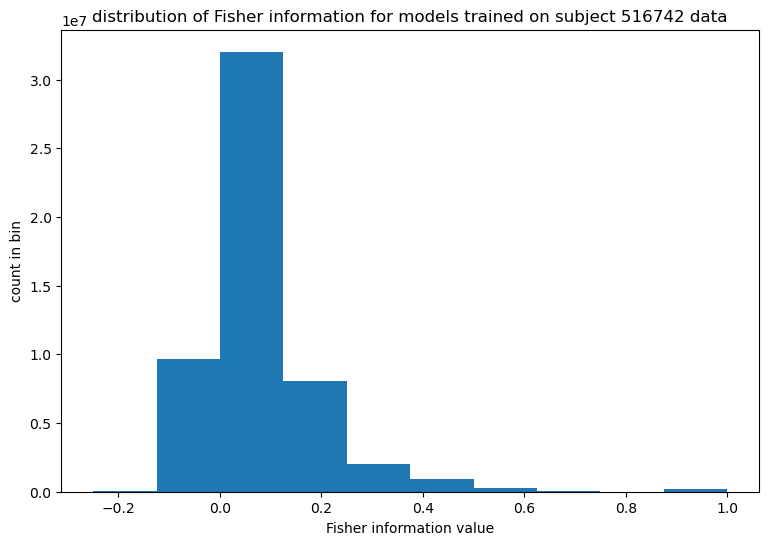

In [34]:
sim_fim_flat = sim_fim_batch.flatten()
plot_value_histogram(name='Fisher information', values=sim_fim_flat, data_subset=f'subject {subject_id}')
# print_stats(name='Fisher information', values=sim_fim_flat)

In [35]:
print(  torch.count_nonzero( sim_fim_flat.abs() < 0.2 )/torch.numel(sim_fim_flat)  )

tensor(0.9017, device='cuda:0')


In [36]:
print(  torch.count_nonzero( (-0.1 < sim_fim_flat) & (sim_fim_flat < 0.3) )/torch.numel(sim_fim_flat)  )

tensor(0.9502, device='cuda:0')


In [37]:
def plot_range_histogram(name:str, values:torch.Tensor, data_subset:str, rep_dim:int=0):
    num_reps = values.size(dim=rep_dim)
    values_ranges = ( values.max(dim=rep_dim).values - values.min(dim=rep_dim).values ).flatten()
    print( values_ranges.min().item(), torch.median(values_ranges).item(), values_ranges.max().item() )
    values_ranges_np = values_ranges.flatten().detach().cpu().numpy()
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    axs.hist(values_ranges_np)
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.set_xlabel(f'range of {name} over {num_reps} repetitions')
    axs.set_ylabel('count in bin')
    axs.set_title(f'distribution of {name} ranges for models trained on {data_subset} data')
    plt.show()

0.0 0.0874553844332695 0.33549532294273376


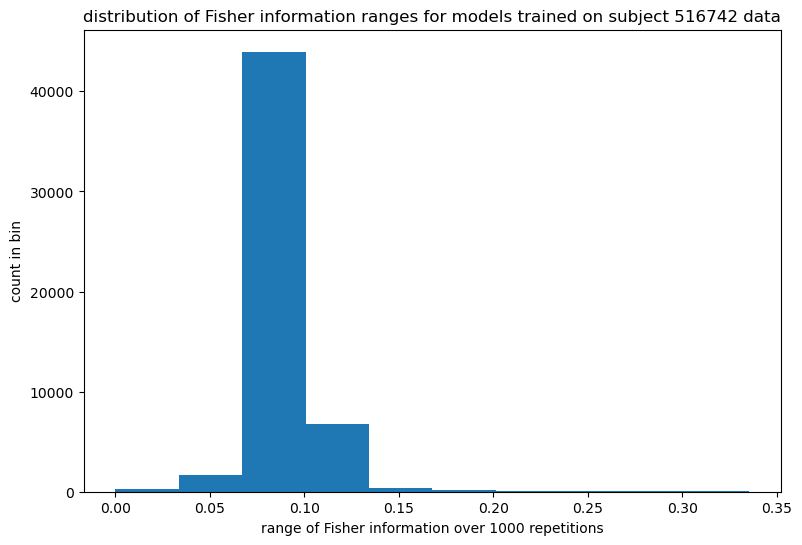

In [38]:
plot_range_histogram(name='Fisher information', values=sim_fim_batch, data_subset=f'subject {subject_id}')

In [39]:
def get_fisher_info_matrix_combined(ts:torch.Tensor):
    print( 'ts size:', ts.size() )
    num_reps = ts.size(dim=0)
    num_nodes = ts.size(dim=-1)
    num_vars = num_nodes + num_nodes*(num_nodes-1)//2
    dtype = ts.dtype
    device = ts.device
    mean_vars = torch.zeros( (num_reps, num_vars), dtype=dtype, device=device )
    mean_of_prods = torch.zeros( (num_reps, num_vars, num_vars), dtype=dtype, device=device )
    ut_indices = torch.triu_indices( row=num_nodes, col=num_nodes, offset=1, device=device )
    for rep in range(num_reps):
        ts_rep = ts[rep,:,:]
        J_vars = ts_rep[:,:,None] * ts_rep[:,None,:]
        # print( 'J_vars size:', J_vars.size() )
        J_vars_ut = J_vars[:, ut_indices[0], ut_indices[1] ]
        # print( 'J_vars_ut size:', J_vars_ut.size() )
        all_vars = torch.cat( (ts_rep, J_vars_ut), dim=-1 )
        # print( 'all_vars size:', all_vars.size() )
        mean_vars[rep,:] = torch.mean(all_vars, dim=0)
        mean_of_prods[rep,:,:] += torch.mean(all_vars[:,:,None] * all_vars[:,None,:], dim=0)
        # print( 'mean_of_prods size:', mean_of_prods.size() )
    mean_mean_vars = mean_vars.mean(dim=0)
    mean_mean_of_prods = mean_of_prods.mean(dim=0)
    return mean_mean_of_prods - mean_mean_vars[:,None] * mean_mean_vars[None,:]

In [40]:
sim_fim = get_fisher_info_matrix_combined(sim_ts_batch)
print( 'FIM size: ', sim_fim.size() )

ts size: torch.Size([1000, 4800, 21])
FIM size:  torch.Size([231, 231])


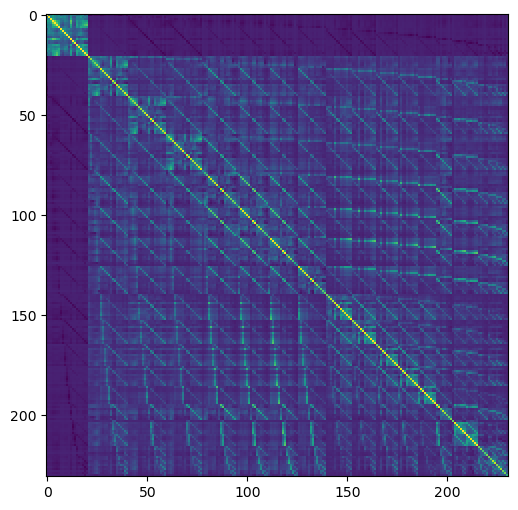

In [41]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.imshow( sim_fim.detach().cpu().numpy() )

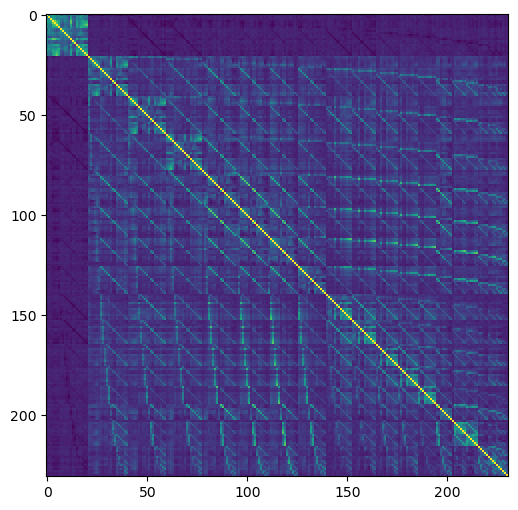

In [42]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.imshow( sim_fim_batch[0,:,:].detach().cpu().numpy() )

In [43]:
L_fim, V_fim = torch.linalg.eig(sim_fim)
print( 'L_fim size:', L_fim.size() )
print( 'V_fim size:', V_fim.size() )

L_fim size: torch.Size([231])
V_fim size: torch.Size([231, 231])


The magnitudes of the eigenvalues of the combined FIM range from 0.0571 to 22.9.


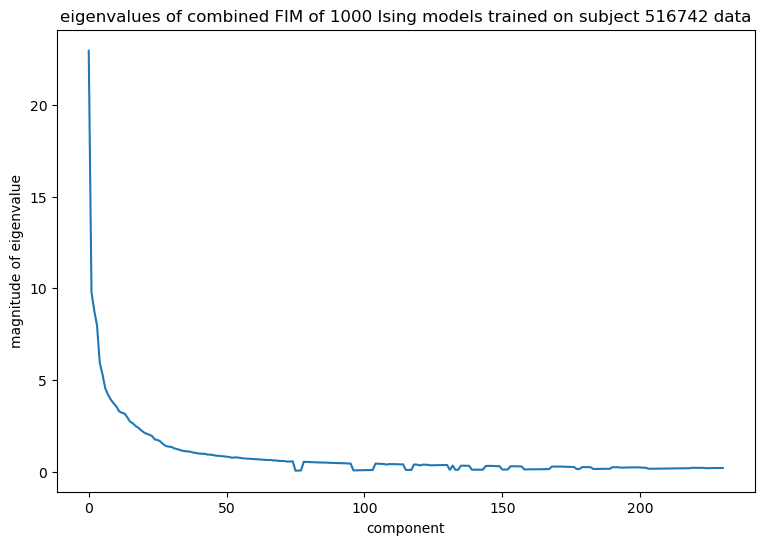

In [44]:
L_fim_abs = L_fim.abs()
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.plot( L_fim_abs.detach().cpu().numpy() )
axs.set_xlabel('component')
axs.set_ylabel('magnitude of eigenvalue')
axs.set_title(f'eigenvalues of combined FIM of {batch_size} Ising models trained on subject {subject_id} data')
print( f'The magnitudes of the eigenvalues of the combined FIM range from {L_fim_abs.min():.3g} to {L_fim_abs.max():.3g}.' )

Text(0.5, 1.0, 'cumulative fraction of magnitudes of 1000 Ising models trained on subject 516742 data')

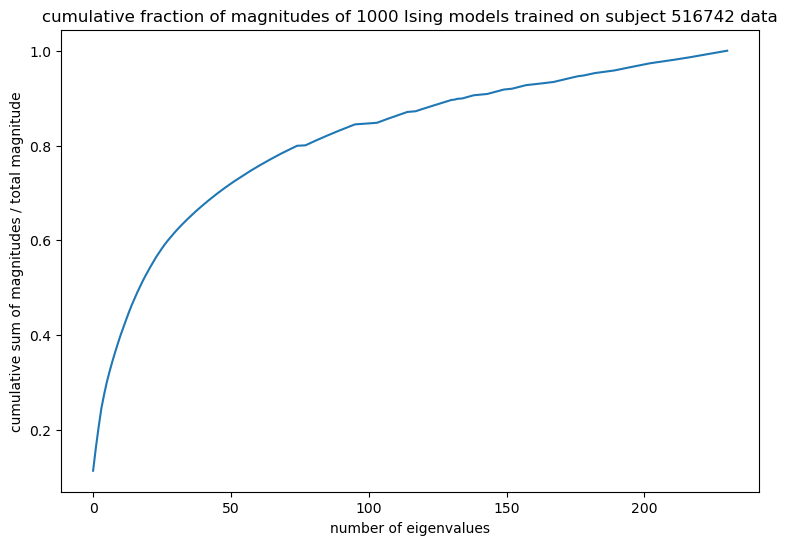

In [45]:
cum_L_fim_abs_exp = torch.cumsum( L_fim_abs/L_fim_abs.sum(), dim=0 )
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.plot( cum_L_fim_abs_exp.detach().cpu().numpy() )
axs.set_xlabel('number of eigenvalues')
axs.set_ylabel('cumulative sum of magnitudes / total magnitude')
axs.set_title(f'cumulative fraction of magnitudes of {batch_size} Ising models trained on subject {subject_id} data')
# print( f'The eigenvalues of the principal components range from {S.min():.3g} to {S.max():.3g}.' )

In [46]:
threshold = 0.95
print( f'number of eigenvalues needed to pass {100*threshold}%: {torch.count_nonzero(cum_L_fim_abs_exp < threshold).item()+1}' )

number of eigenvalues needed to pass 95.0%: 181


In [47]:
# Find the Gini coefficient.
# num_eigs = L_fim_abs.numel()
# definition from https://www.jneurosci.org/content/35/22/8480
# L_fim_gini = 1 - 2 * torch.sum(  L_fim_abs * ( num_eigs - 0.5 - torch.arange(num_eigs, dtype=float_type, device=device) )/num_eigs  )/torch.sum(L_fim_abs)
# does not match the definition in https://en.wikipedia.org/wiki/Gini_coefficient
L_fim_gini = torch.mean( (L_fim_abs[:,None] - L_fim_abs[None,:]).abs() )/( 2.0 * torch.mean(L_fim_abs) )
print(f'Gini coefficient of the eigenvalue magnitudes: {L_fim_gini:.3g}')

Gini coefficient of the eigenvalue magnitudes: 0.645


In [48]:
print( 'largest imaginary part of a FIM eigenvector element:', V_fim.imag.abs().max() )
print( 'largest imaginary part of a FIM eigenvalue:', L_fim.imag.abs().max() )

largest imaginary part of a FIM eigenvector element: tensor(0., device='cuda:0')
largest imaginary part of a FIM eigenvalue: tensor(0., device='cuda:0')


Text(0.5, 1.0, 'eigenvectors of Fisher information matrix')

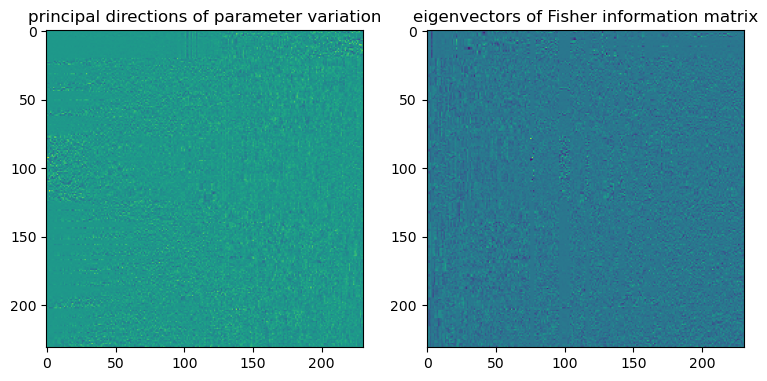

In [49]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 6))
axs[0].imshow( V.detach().cpu().numpy() )
axs[0].set_title(f'principal directions of parameter variation')
axs[1].imshow( V_fim.real.detach().cpu().numpy() )
axs[1].set_title(f'eigenvectors of Fisher information matrix')
# axs[2].imshow( V_fim.imag.detach().cpu().numpy() )
# axs[2].set_title(f'imaginary part of eigenvectors of Fisher information matrix')

In [50]:
# Let vecs1 and vecs2 be 2D matrices in which each column is a vector.
# Return the cosine similarities between all pairs of one column from vecs1 and one column from vecs2.
def cosine_similarity_all_pairs(vecs1:torch.Tensor, vecs2:torch.Tensor):
    pair_products = torch.matmul( vecs1.transpose(dim0=-2, dim1=-1), vecs2 )
    print( 'pair_products size:', pair_products.size() )
    norms1 = torch.norm(vecs1, p=2, dim=-2)
    print( 'norms1 size:', norms1.size() )
    norms2 = torch.norm(vecs2, p=2, dim=-2)
    print( 'norms2 size:', norms2.size() )
    normalizers = norms1.unsqueeze(dim=-1) * norms2.unsqueeze(dim=-2)
    print( 'normalizers size:', normalizers.size() )
    return pair_products/normalizers

In [51]:
test_vecs1 = torch.tensor([[3,0,0],[0,3,0],[4,0,3],[0,4,0],[0,0,4]], dtype=float_type, device=device)
test_vecs2 = torch.tensor([[5,5,0,0],[0,0,5,0],[12,0,0,5],[0,0,0,12],[0,12,12,0]], dtype=float_type, device=device)
print( cosine_similarity_all_pairs(test_vecs1, test_vecs2) )

pair_products size: torch.Size([3, 4])
norms1 size: torch.Size([3])
norms2 size: torch.Size([4])
normalizers size: torch.Size([3, 4])
tensor([[0.9692, 0.2308, 0.0000, 0.3077],
        [0.0000, 0.0000, 0.2308, 0.7385],
        [0.5538, 0.7385, 0.7385, 0.2308]], device='cuda:0')


pair_products size: torch.Size([231, 231])
norms1 size: torch.Size([231])
norms2 size: torch.Size([231])
normalizers size: torch.Size([231, 231])
V_fim_V_cos_sims size: torch.Size([231, 231])


Text(0.5, 1.0, 'cosine similarities: parameter variation PCs vs FIM eigenvectors')

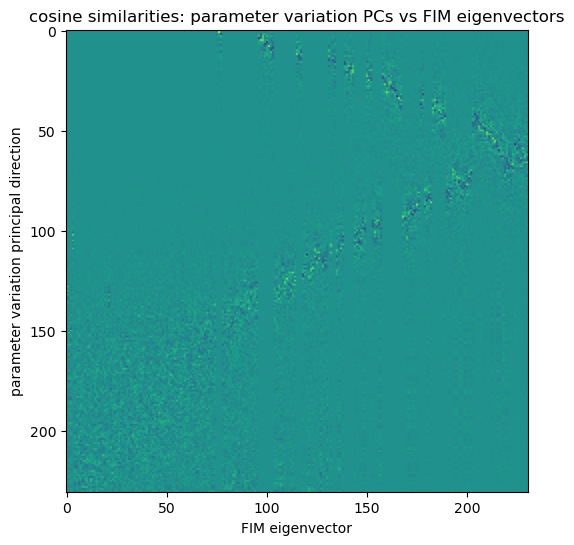

In [52]:
V_fim_V_cos_sims = cosine_similarity_all_pairs(V, V_fim.real)
print( 'V_fim_V_cos_sims size:', V_fim_V_cos_sims.size() )
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.imshow( V_fim_V_cos_sims.detach().cpu().numpy() )
axs.set_ylabel('parameter variation principal direction')
axs.set_xlabel('FIM eigenvector')
axs.set_title(f'cosine similarities: parameter variation PCs vs FIM eigenvectors')

In [53]:
print(V_fim_V_cos_sims[ [0,0,-1,-1], [0,-1,0,-1] ])

tensor([-0.0010,  0.0004, -0.0267,  0.0043], device='cuda:0')


Text(0.5, 1.0, 'projections of parameter variation onto FIM eigenvectors for 1000 Ising models trained on subject 516742 data')

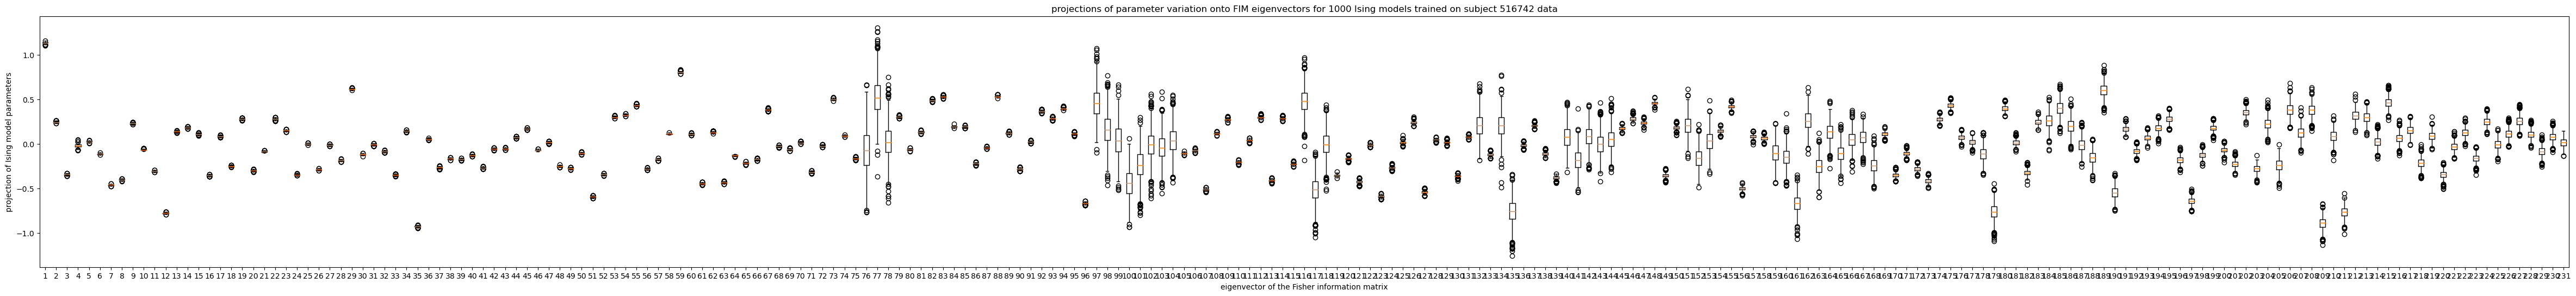

In [54]:
params_times_V_fim = torch.matmul(params_flat, V_fim.real)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(60, 6))
axs.boxplot( params_times_V_fim.detach().cpu().numpy() )
# axs.set_xticklabels(param_names, rotation=45, ha='right')
axs.set_xlabel('eigenvector of the Fisher information matrix')
axs.set_ylabel('projection of Ising model parameters')
axs.set_title(f'projections of parameter variation onto FIM eigenvectors for {batch_size} Ising models trained on subject {subject_id} data')

Text(0.5, 1.0, 'parameter variance along eigenvector vs eigenvalue')

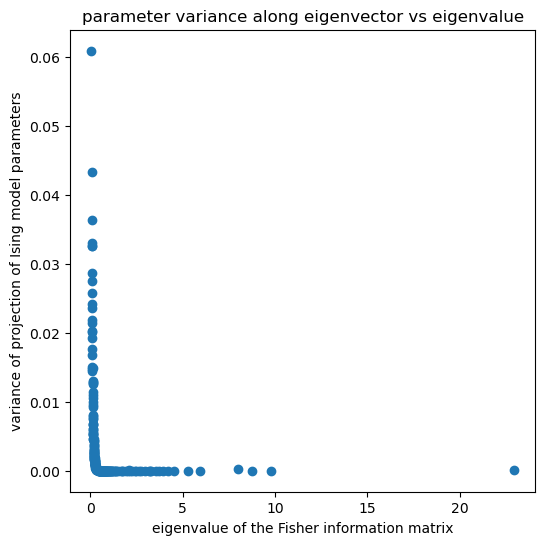

In [55]:
params_times_V_fim_variance = params_times_V_fim.var(dim=0)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
axs.scatter( L_fim.real.detach().cpu().numpy(), params_times_V_fim_variance.detach().cpu().numpy() )
# axs.set_xticklabels(param_names, rotation=45, ha='right')
axs.set_xlabel('eigenvalue of the Fisher information matrix')
axs.set_ylabel('variance of projection of Ising model parameters')
axs.set_title(f'parameter variance along eigenvector vs eigenvalue')

In [56]:
corr_var_vs_eig = torch.corrcoef(  torch.stack( (params_times_V_fim_variance,L_fim.real), dim=0 )  )
print( corr_var_vs_eig.size() )
print( f'correlation between eigenvalue and variance of projections of parameters onto eigenvector: {corr_var_vs_eig[0,1].item():.3g}' )

torch.Size([2, 2])
correlation between eigenvalue and variance of projections of parameters onto eigenvector: -0.177


Text(0.5, 1.0, 'parameter variance along eigenvector vs eigenvalue')

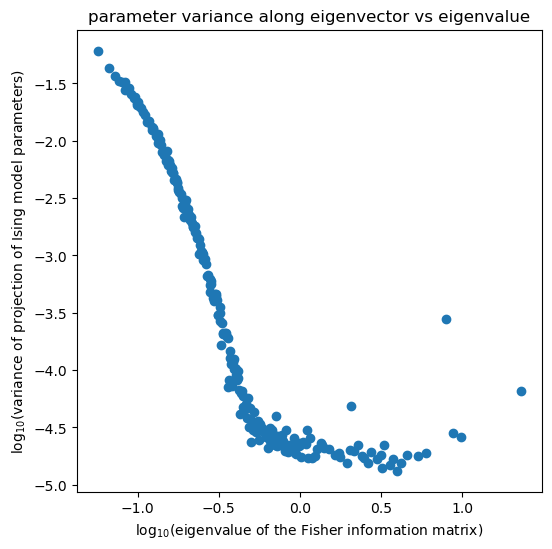

In [57]:
params_times_V_fim_variance = params_times_V_fim.var(dim=0)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
axs.scatter( torch.log10(L_fim.real).detach().cpu().numpy(), torch.log10(params_times_V_fim_variance).detach().cpu().numpy() )
# axs.set_xticklabels(param_names, rotation=45, ha='right')
axs.set_xlabel('log$_{10}$(eigenvalue of the Fisher information matrix)')
axs.set_ylabel('log$_{10}$(variance of projection of Ising model parameters)')
axs.set_title(f'parameter variance along eigenvector vs eigenvalue')

In [58]:
log_V_fim_project_var = torch.log10(params_times_V_fim_variance)
log_L_fim = torch.log10(L_fim.real)
corr_var_vs_eig = torch.corrcoef(  torch.stack( (log_V_fim_project_var,log_L_fim), dim=0 )  )
print( corr_var_vs_eig.size() )
print( f'correlation between eigenvalue and variance of projections of parameters onto eigenvector in log-log space: {corr_var_vs_eig[0,1].item():.3g}' )

torch.Size([2, 2])
correlation between eigenvalue and variance of projections of parameters onto eigenvector in log-log space: -0.854


Text(0.5, 1.0, 'parameter variance along eigenvector vs eigenvalue')

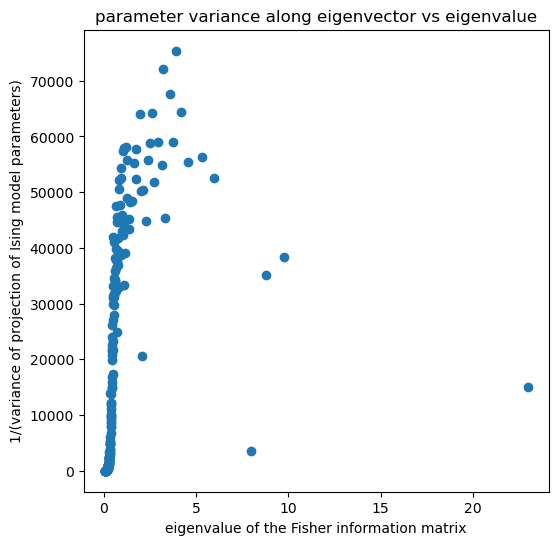

In [59]:
inv_params_times_V_fim_variance = 1.0/params_times_V_fim_variance
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
axs.scatter( L_fim.real.detach().cpu().numpy(), inv_params_times_V_fim_variance.detach().cpu().numpy() )
# axs.set_xticklabels(param_names, rotation=45, ha='right')
axs.set_xlabel('eigenvalue of the Fisher information matrix')
axs.set_ylabel('1/(variance of projection of Ising model parameters)')
axs.set_title(f'parameter variance along eigenvector vs eigenvalue')

In [60]:
corr_var_vs_eig = torch.corrcoef(  torch.stack( (inv_params_times_V_fim_variance,L_fim.real), dim=0 )  )
print( corr_var_vs_eig.size() )
print( f'correlation between eigenvalue and 1/variance of projections of parameters onto eigenvector: {corr_var_vs_eig[0,1].item():.3g}' )

torch.Size([2, 2])
correlation between eigenvalue and 1/variance of projections of parameters onto eigenvector: 0.365


Text(0.5, 1.0, 'parameter variance along eigenvector vs eigenvalue')

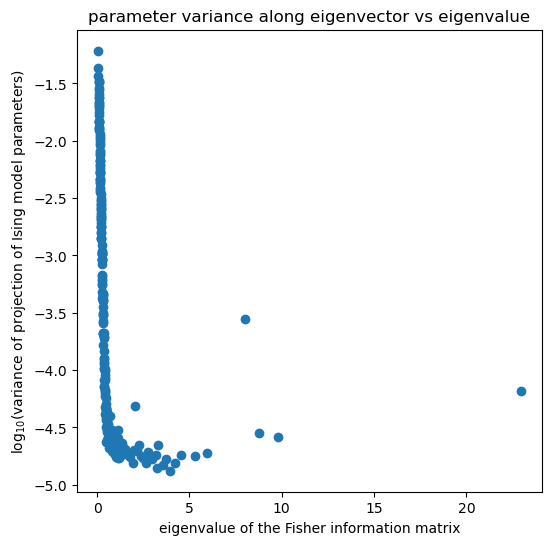

In [61]:
params_times_V_fim_variance = params_times_V_fim.var(dim=0)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
axs.scatter( L_fim.real.detach().cpu().numpy(), torch.log10(params_times_V_fim_variance).detach().cpu().numpy() )
# axs.set_xticklabels(param_names, rotation=45, ha='right')
axs.set_xlabel('eigenvalue of the Fisher information matrix')
axs.set_ylabel('log$_{10}$(variance of projection of Ising model parameters)')
axs.set_title(f'parameter variance along eigenvector vs eigenvalue')

In [62]:
print(360 + 360*(360-1)/2)

64980.0
